In [59]:
import os
os.environ["OMP_NUM_THREADS"] = "32"

In [60]:
from contextlib import contextmanager
import argparse
import os.path
import csv
import time
import sys
from functools import partial
import shutil as sh

from graph_tool.all import *
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.covariance import LedoitWolf, OAS
import statsmodels.api as sm

from multipy.fdr import lsu

In [61]:
from fit_sbm import *
from trim_networks import *

In [62]:
g = load_graph("../data/output/SBM/graphs/head_fdrLevel-0.0001_genes-3589_density-0.021.xml.gz")
corr = g.edge_properties['spearman']
g.ep.z_s = g.new_edge_property("double", (2*np.arctanh(corr.a)))

In [64]:
graph_file = "../data/output/SBM/clustering/head_weights-spearman_fdr-1e-04_mcmc_mode_hierarchical-SBM.dill"
with open (graph_file, "rb") as fh:
    bs = dill.load(fh)
       

In [65]:
graph_file = "../data/output/SBM/clustering/head_weights-spearman_fdr-1e-04_absolute_mcmc_mode_hierarchical-SBM.dill"
with open (graph_file, "rb") as fh:
    bs_abs = dill.load(fh)
       

In [73]:
nested_partition_overlap(bs, bs_abs, norm = True)

0.5196292257360959

In [75]:
state = minimize_nested_blockmodel_dl(g, init_bs=bs, 
                                      state_args=dict(recs=[g.ep.z_s],
                                                      rec_types=["real-normal"]))

In [76]:
N = len(gf.get_vertices())
Et = (N * N - N)/2
E = len(gf.get_edges())
[N, E, E/Et]

[3589, 133757, 0.020774023687515394]

In [80]:
M = []
for i in range(4):
    M.append(modularity(state.levels[i].g, state.levels[i].b,
             weight=state.levels[i].eweight))
M

[0.059614803395064316,
 0.1866219078184302,
 0.2863006188872337,
 0.31235909203149]

In [88]:
block_df = pd.read_csv("../data/output/SBM/clustering/head_weights-spearman_fdr-1e-04_mcmc_mode_hierarchical-SBM.csv")


In [95]:
blocks = [list(set(block_df[b])) for b in block_df.filter(like='B', axis=1)]
block_sizes = [len(b) for b in blocks]
block_sizes = -np.sort(-np.array(list(set(block_sizes))))
block_sizes = [x for x in block_sizes if x >= 2]

print("Creating gene lists...")
n_levels = len(block_sizes)
output_df = pd.DataFrame(columns=('Nested_Level', 'Block', 'File', 'N_genes', 'Internal_degree', 'Assortatitvity'))
i = 0
bl = blocks[i]
assort = []
for b in bl:

    line = [i+1]
    line.append(b)

    df = block_df[block_df['B' + str(i+1)]==b]
    genes = df["Gene"]
    file_name = "/" + '-'.join([str(num) for num in list(df.filter(like='B', axis=1).iloc[0,range(i, n_levels)])]) + ".csv"

    line.append(file_name)
    line.append(genes.shape[0])

    # Weighted
    ers = adjacency(state.levels[i].bg, weight=state.levels[i].mrs)
    B = len(bl)
    E = ers.sum()
    q_r = (B/E) * (ers[b,b] - (ers[b,:].sum()**2/E))
    assort.append(q_r)
    line.append(ers[b,b])
    line.append(q_r)

    output_df.loc[l] = line


Creating gene lists...


In [101]:
np.mean(assort)

0.059614803395064295

In [ ]:
%%time

S1 = state.entropy()

mcmc_anneal(state, beta_range=(1, 10), 
            niter=1000, mcmc_equilibrate_args=dict(force_niter=10),
            verbose = False)

S2 = state.entropy()

print("Improvement:", S2 - S1)

In [56]:
levels = state.get_levels()
block_sizes = [s.get_nonempty_B() for s in levels]
is_small = [b == min(block_sizes) for b in block_sizes]
for i in range(len(is_small)):
    if is_small[i]:
        break
block_sizes

[56, 14, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [57]:
block_state = state.get_bs()
block_state

[PropertyArray([ 545,  255,  997, ...,  631, 3566,  375], dtype=int32),
 PropertyArray([ 4, 38,  0, ..., 53,  0, 42], dtype=int32),
 PropertyArray([10,  0, 14, 10, 11,  0,  8,  2,  8, 14,  4, 10,  7, 10, 14,
                12,  6, 10, 10, 10,  6, 14, 14,  8, 11, 14,  6,  6, 11, 14,
                14,  6, 14,  2, 14,  8, 10, 10, 10, 10, 14, 11,  8,  6,  8,
                 6,  3,  0,  2, 10,  7, 11, 11, 11], dtype=int32),
 PropertyArray([0, 5, 4, 5, 7, 5, 5, 6, 5, 0, 0, 5, 5, 4, 0], dtype=int32),
 PropertyArray([3, 1, 2, 2, 4, 4, 3, 1], dtype=int32),
 PropertyArray([4, 2, 2, 0, 2, 2], dtype=int32),
 PropertyArray([1, 1, 2, 2, 1], dtype=int32),
 PropertyArray([3, 0, 2, 3], dtype=int32),
 PropertyArray([3, 3, 1, 3], dtype=int32),
 PropertyArray([1, 3, 0, 0], dtype=int32),
 PropertyArray([2, 1, 2, 0], dtype=int32),
 PropertyArray([1, 3, 2], dtype=int32),
 PropertyArray([1, 1, 3, 3], dtype=int32)]

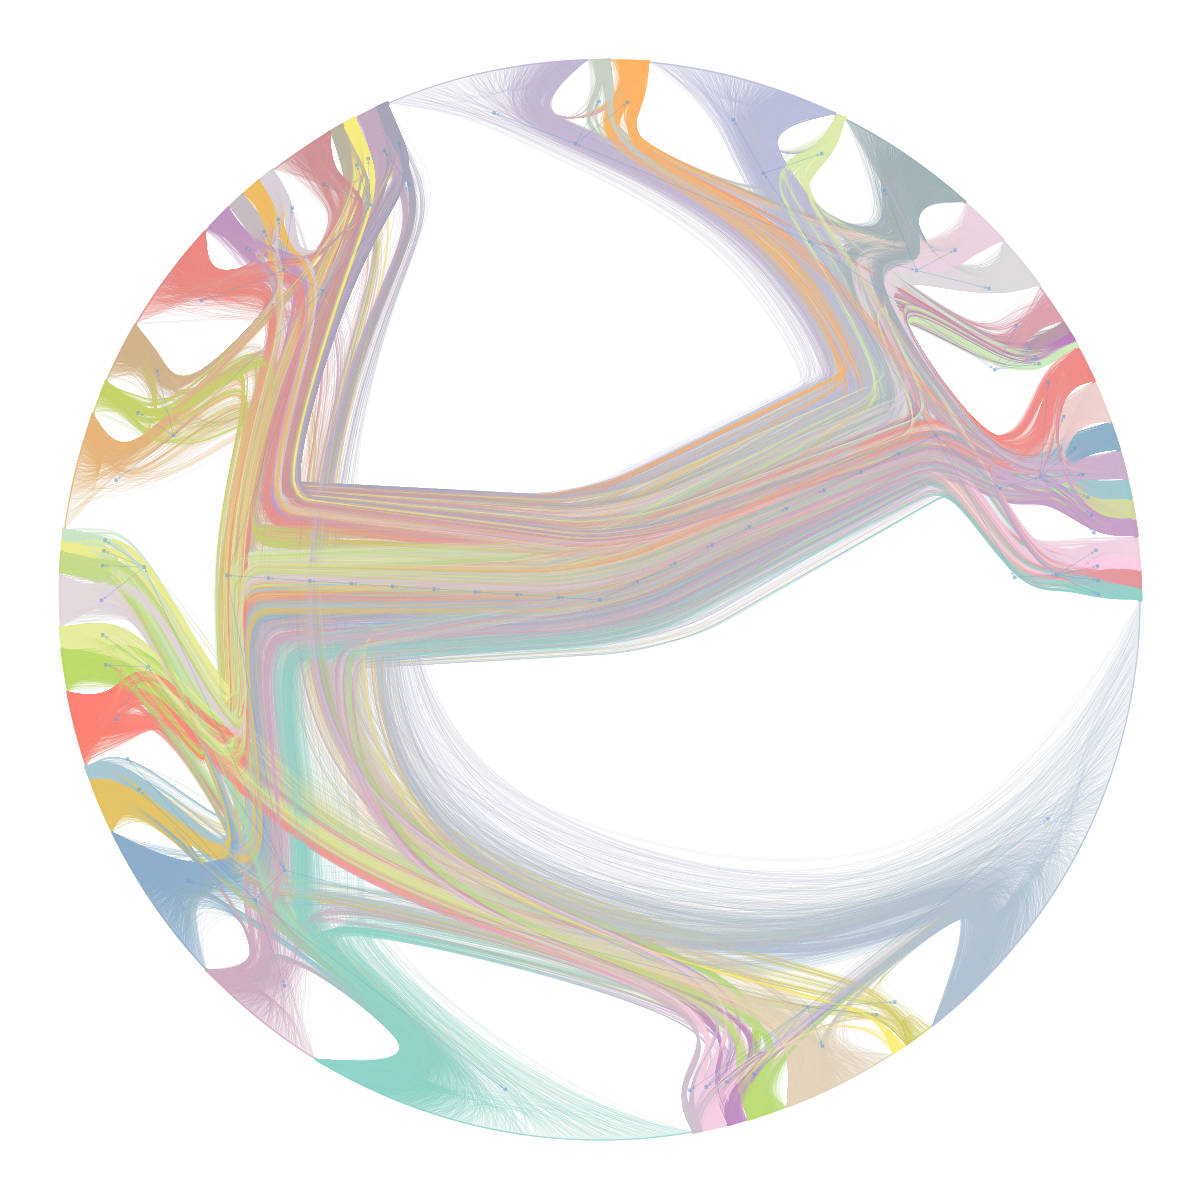

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f5dc2988d60, at 0x7f5d90838ca0>,
 <Graph object, directed, with 3683 vertices and 3682 edges, at 0x7f5acd0c7910>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f5acd0c7910, at 0x7f5d90838130>)

In [21]:
state.draw()

In [ ]:
%%time

bs = []
h = [np.zeros(gf.num_vertices() + 1) for s in state_min.get_levels()]

def collect_partitions(s):
    global bs
    bs.append(s.get_bs())
    for l, sl in enumerate(s.get_levels()):
       B = sl.get_nonempty_B()
       h[l][B] += 1
   
mcmc_equilibrate(state_min, force_niter=10000, mcmc_args=dict(niter=10),
                    callback=collect_partitions)

In [ ]:
# Disambiguate partitions and obtain marginals
pmode = PartitionModeState(bs, nested=True, converge=True)

In [ ]:
pv = pmode.get_marginal(gf)

# Get consensus estimate
bs = pmode.get_max_nested()

state_nested_mode = state_min.copy(bs=bs)

In [29]:
state_pp = minimize_blockmodel_dl(g, 
                #state=PPBlockState, 
                state_args=dict(recs=[g.ep.z_s],
                                rec_types=["real-normal"]))
#mcmc_equilibrate(state_pp, wait = 1000, mcmc_args=dict(niter=10))

In [ ]:
%%time

S1 = state.entropy()

mcmc_anneal(state_pp, beta_range=(1, 10), 
            niter=100, mcmc_equilibrate_args=dict(force_niter=10),
            verbose = True)

S2 = state.entropy()

print("Improvement:", S2 - S1)

In [ ]:
state_min_pp.draw()

In [ ]:
state_pp = BlockState(gf, b=state_min_pp.b)
B = state_pp.get_nonempty_B()
e_mat = state_pp.get_matrix().todense()[:B, :B]

In [ ]:
state_min_pp.b

In [ ]:
state_pp.get_matrix().todense()